# Введение

Кристина, здравствуйте!

В этом уроке я честно старался довать backbone и аугментацию. В первом случая я понял, что detectron2 так себе приспособлен к модификации и внесения функционала, который не был заложен сначало. Эта часть кода с моими попытками не сохранилась. Во втором случаи аугментация вроде работает, но почему-то течет память, и я получал ошибки. Все рекомендации с форумов я также перепробывал. Причина точне не в размере батча или размере изображения. 

Единственно на что мне хватило времени это обучить самую лучшую модель, что есть в detectron2. Надеюсь этого хватит, чтобы оценить меня

# 1 Попытки добавить аугментации
Вечная проблема с памятью в Detectron2. Формумы говорят, что решения нет. Только зря время потратил.


In [7]:
import os
import cv2
import random
import matplotlib.pyplot as plt
import numpy as np
import torch

from detectron2.utils.logger import setup_logger
setup_logger()

from detectron2 import model_zoo
from detectron2.engine import DefaultTrainer, DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.data.datasets import register_coco_instances
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

# Albumentations
import albumentations as A
from detectron2.data import detection_utils as utils
from detectron2.data import DatasetMapper
from detectron2.data import build_detection_train_loader
from detectron2.data import transforms as T



# Регистрация датасета
data_dir = "../data/Bamberg_coco2048/coco2048"
register_coco_instances("tree_train", {}, f"{data_dir}/annotations/instances_tree_train2023.json", f"{data_dir}/train2023")
register_coco_instances("tree_val", {}, f"{data_dir}/annotations/instances_tree_eval2023.json", f"{data_dir}/val2023")


/media/paralamg/845E4AB55E4AA032/Code/uforest/.venv/lib/python3.13/site-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.8' (you have '2.0.7'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
## 3. Исследование аннотаций
from detectron2.data import DatasetCatalog

sample = DatasetCatalog.get("tree_train")[0]
print("Пример записи в датасете:", sample)

[05/27 23:14:39 d2.data.datasets.coco]: Loading ../data/Bamberg_coco2048/coco2048/annotations/instances_tree_train2023.json takes 1.53 seconds.
[05/27 23:14:39 d2.data.datasets.coco]: Loaded 1439 images in COCO format from ../data/Bamberg_coco2048/coco2048/annotations/instances_tree_train2023.json
Пример записи в датасете: {'file_name': '../data/Bamberg_coco2048/coco2048/train2023/Stadtwald_115_0.tif', 'height': 2048, 'width': 2048, 'image_id': 1, 'annotations': [{'iscrowd': 0, 'bbox': [469.0, 28.0, 325.0, 471.0], 'category_id': 0, 'segmentation': [[762.0, 498.5, 722.0, 496.5, 705.0, 488.5, 682.0, 485.5, 657.0, 473.5, 643.5, 461.0, 621.5, 431.0, 613.5, 415.0, 597.0, 398.5, 587.0, 391.5, 538.0, 378.5, 518.5, 360.0, 510.5, 338.0, 510.5, 311.0, 502.5, 286.0, 504.5, 244.0, 493.0, 231.5, 478.5, 223.0, 468.5, 207.0, 469.5, 195.0, 477.5, 178.0, 515.5, 144.0, 506.5, 109.0, 510.0, 92.5, 539.0, 84.5, 597.0, 56.5, 657.0, 50.5, 669.0, 47.5, 698.0, 32.5, 716.0, 32.5, 725.0, 27.5, 745.0, 27.5, 749.0

In [3]:
## 4. Конфигурация модели (улучшенная архитектура)
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml"))
cfg.OUTPUT_DIR = "../models/rcnn_R_101"
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

cfg.DATASETS.TRAIN = ("tree_train",)
cfg.DATASETS.TEST = ("tree_val",)
cfg.DATALOADER.NUM_WORKERS = 1
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
# cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
cfg.SOLVER.IMS_PER_BATCH = 1
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 100
cfg.SOLVER.STEPS = []
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1
cfg.INPUT.MIN_SIZE_TRAIN = (100,)
cfg.INPUT.MAX_SIZE_TRAIN = 200



In [4]:
augmentations = [
    # T.RandomFlip(prob=0.5, horizontal=True, vertical=False),
    # T.RandomRotation(angle=[-15, 15], sample_style="range"),
    # T.RandomBrightness(0.8, 1.2),
    # T.RandomContrast(0.8, 1.2),
    # T.RandomSaturation(0.8, 1.2),
]

# Кастомный Trainer с аугментациями
class AugmentedTrainer(DefaultTrainer):
    @classmethod
    def build_train_loader(cls, cfg):
        mapper = DatasetMapper(
            cfg, 
            is_train=True,
            augmentations=augmentations,
            image_format="BGR"
        )
        return build_detection_train_loader(cfg, mapper=mapper)

In [5]:
trainer = AugmentedTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()


[05/27 23:14:41 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

OutOfMemoryError: CUDA out of memory. Tried to allocate 64.00 MiB. GPU 0 has a total capacity of 3.94 GiB of which 27.38 MiB is free. Including non-PyTorch memory, this process has 3.91 GiB memory in use. Of the allocated memory 3.81 GiB is allocated by PyTorch, and 44.95 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

# 2. Обучение более продвинутой модели без аугментации

In [8]:
## 4. Конфигурация модели (улучшенная архитектура)
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml"))
cfg.OUTPUT_DIR = "../models/rcnn_R_101"
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

cfg.DATASETS.TRAIN = ("tree_train",)
cfg.DATASETS.TEST = ("tree_val",)
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
# cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml")

cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 10000
cfg.SOLVER.STEPS = []
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1

In [ ]:
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

## Оценка модели

In [11]:
import torch
torch.cuda.empty_cache()


predictor = DefaultPredictor(cfg)

[05/28 21:40:07 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ../models/rcnn_R_101/model_final.pth ...


In [ ]:

torch.cuda.empty_cache()
evaluator = COCOEvaluator("tree_val", cfg, False, output_dir="./output")
val_loader = build_detection_test_loader(cfg, "tree_val", batch_size=2, num_workers=0)
inference_on_dataset(predictor.model, val_loader, evaluator)

Сравнительная таблица старой модели mask_rcnn_R_50_FPN_3x и новой mask_rcnn_R_101_FPN_3x

| Модель                          | Метрика | AP (%)       | AP50 (%)    | AP75 (%)    | APs (%)     | APm (%)     | APl (%)     |
|---------------------------------|---------|--------------|-------------|-------------|-------------|-------------|-------------|
| mask_rcnn_R_50_FPN_3x          | bbox    | 35.27       | 60.88       | 38.34       | 0.00        | 5.85        | 39.16       |
|                                 | segm    | 35.93       | 60.82       | 40.02       | 0.20        | 4.52        | 39.93       |
| mask_rcnn_R_101_FPN_3x         | bbox    | 37.12       | 64.18       | 39.59       | 0.00        | 7.29        | 41.25       |
|                                 | segm    | 37.28       | 64.09       | 41.45       | 0.00        | 5.95        | 41.37       |


Общие выводы:
1. Новая модель однозначно лучше по большинству метрик благодаря более мощному бэкбону (ResNet-101 vs ResNet-50).
2. Наибольший прирост наблюдается для крупных объектов (APl) и метрик с низким порогом IoU (AP50).
3. Критическая проблема обоих модели — полная деградация на мелких объектах (APs = 0% для обеих задач).

Что касается мелких объектов (см. рисунок в следующем разделе), то многие из них расположены близко друг к другу и часто относятся к одному классу. Это приводит к тому, что модель объединяет их в одну маску, соответствующую среднему или крупному дереву. Эту проблему можно было бы решить заменой бэкбона (backbone) на более современную архитектуру, сохраняющую детализацию мелких объектов. Однако ни времени, ни технических возможностей для такой замены, к сожалению, нет.

## Пример работы модели и пост обработка

In [9]:
# Постобработка данных для обучения модели Mask R-CNN будет заключатся только в одном изменении конфигурации модели.
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5

[05/28 21:40:11 d2.data.datasets.coco]: Loaded 382 images in COCO format from ../data/Bamberg_coco2048/coco2048/annotations/instances_tree_eval2023.json


/media/paralamg/845E4AB55E4AA032/Code/uforest/.venv/lib/python3.13/site-packages/torch/functional.py:554: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:4314.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


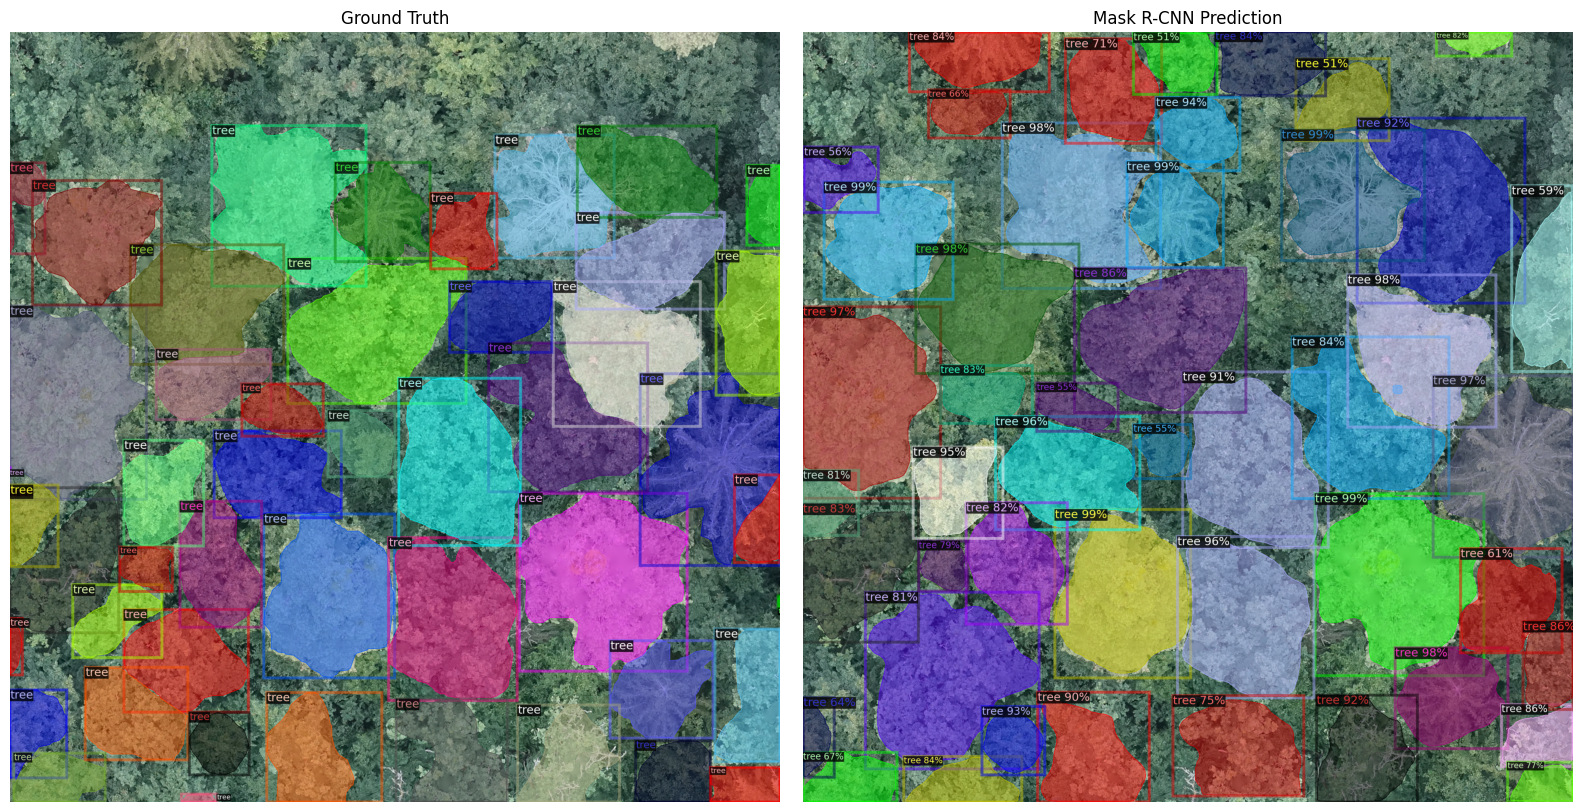

In [12]:

from detectron2.data import MetadataCatalog, DatasetCatalog

dataset_dicts = DatasetCatalog.get("tree_val")
# sample = random.choice(dataset_dicts)  # случайное изображение
sample = dataset_dicts[1]  
file_path = sample["file_name"]
image = cv2.imread(file_path)
outputs_2 = predictor(image)

# === Визуализация предсказания ===
v_pred_2 = Visualizer(image[:, :, ::-1], MetadataCatalog.get("tree_val"), scale=1.0)
out_pred_2 = v_pred_2.draw_instance_predictions(outputs_2["instances"].to("cpu"))

# === Визуализация разметки (GT) ===
v_gt = Visualizer(image[:, :, ::-1], MetadataCatalog.get("tree_val"), scale=1.0)
out_gt = v_gt.draw_dataset_dict(sample)

# === Сравнительный вывод ===
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

ax[0].imshow(out_gt.get_image())
ax[0].set_title("Ground Truth")
ax[0].axis("off")

ax[1].imshow(out_pred_2.get_image())
ax[1].set_title("Mask R-CNN Prediction")
ax[1].axis("off")


plt.tight_layout()
plt.show()

# Выводы

Благодаря модели mask_rcnn_R_101_FPN_3x удалось улучшить предсказания как в bbox так и сегментации. Из визуализация предсказаний моделей можно сделать вывод, что большая часть крон деревьев была обнаружена правильно. На основании этих масок легко пострость точки с местоположением деревьев на карте. 